In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import sourses.paths as path
import sourses.class_id as class_id
import sourses.prepare_data as prepare_data

## Global parameters

In [2]:
model_name = 'model_21'

train_path = path.train_path_43
test_path = path.test_path_43

batch_size = prepare_data.batch_size
img_height = prepare_data.img_height
img_width = prepare_data.img_width

epochs = 10

## Loading data from local
- The train data is split into training data and valitation data

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [4]:
print(train_ds.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123
)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False
)

Found 39209 files belonging to 43 classes.


In [7]:
class_names = train_ds.class_names
for i,j in enumerate(class_names):
    class_names[i] = class_id.class_id[j]
    
num_classes = len(class_names)

In [8]:
##Cache the dataset in-memory
train_dataset = train_ds.cache()
val_dataset = val_ds.cache()
train_dataset = train_dataset.repeat().shuffle(buffer_size=512).batch(batch_size) 
val_dataset = val_dataset.batch(batch_size)

train_dataset = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_ds.prefetch(tf.data.experimental.AUTOTUNE)

## Data standardization

In [9]:
IMG_SIZE = 180

normalization_layer = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Data augmentation

In [10]:
data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
     tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.45),
     tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
     ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = val_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## Building the model

In [11]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [13]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True
my_callback = MyThresholdCallback(threshold=0.99)

## Training the model

In [14]:
training = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[my_callback],
    epochs=epochs
)

Epoch 1/10
981/981 [==============================] - 450s 459ms/step - loss: 3.3735 - accuracy: 0.0938 - val_loss: 3.0586 - val_accuracy: 0.1618
Epoch 2/10
981/981 [==============================] - 474s 483ms/step - loss: 2.4887 - accuracy: 0.2864 - val_loss: 1.8997 - val_accuracy: 0.4292
Epoch 3/10
981/981 [==============================] - 467s 476ms/step - loss: 1.7625 - accuracy: 0.4567 - val_loss: 1.6130 - val_accuracy: 0.5041
Epoch 4/10
981/981 [==============================] - 486s 495ms/step - loss: 1.5607 - accuracy: 0.5078 - val_loss: 1.5127 - val_accuracy: 0.5175
Epoch 5/10
981/981 [==============================] - 524s 534ms/step - loss: 1.4447 - accuracy: 0.5387 - val_loss: 1.3379 - val_accuracy: 0.5771
Epoch 6/10
981/981 [==============================] - 482s 491ms/step - loss: 1.3588 - accuracy: 0.5635 - val_loss: 1.2827 - val_accuracy: 0.5995
Epoch 7/10
981/981 [==============================] - 487s 497ms/step - loss: 1.3042 - accuracy: 0.5779 - val_loss: 1.2241 -

## Evaluating its performance

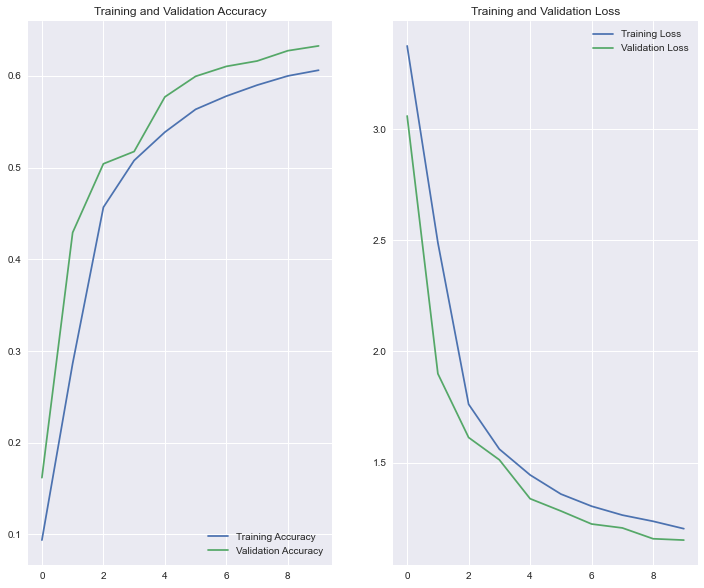

In [15]:
plt.style.use('seaborn')

acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.savefig(f'../outputs/charts/{model_name}.png')
plt.show()

## Model evaluation

In [16]:
results = model.evaluate(test_ds, batch_size=32)

1226/1226 [==============================] - 246s 200ms/step - loss: 1.1318 - accuracy: 0.6338


## Saving the model

In [17]:
# Save the entire model as a SavedModel.
model.save(f'../outputs/models/{model_name}')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(f'../outputs/models/{model_name}.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../outputs/models/model_21/assets
